## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pathlib
import os
import copy
import datetime
import time

import seaborn as sns

## Import the preprocessed data with percentages

In [2]:
df=pd.read_csv("C:\\Users\\Alya\\Documents\\CanDev\\Preprocessed_Data_with_Label.csv", sep=',',encoding='utf8')

## Label columns

In [3]:
#define the label columns as answers to the questions regarding mobility: questions 163 and 164

label_columns=['ANSWER1_163', 'ANSWER2_163', 'ANSWER3_163', 'ANSWER1_164', 'ANSWER2_164', 'ANSWER3_164', 'ANSWER4_164', 'ANSWER5_164', 'ANSWER6_164']

## Define new labels

In [4]:
#dataframe of labels only, in percentages
label_df_percent=df[label_columns].copy(deep=True)

#labels only, in decimals
label_df_decimals=label_df_percent.div(10, axis='columns')

#label_df_decimals.head()

In [5]:
#Label_1: whether people want to leave
Label_1=label_df_decimals['ANSWER1_163'].floordiv(1).astype(int)

#Label_2: if people don't know whether they want to leave
Label_2=label_df_decimals['ANSWER3_163'].floordiv(1).astype(int)

#Label_3: if people are leaving for another place, that is not retirement
Label_3_unfloored=label_df_decimals['ANSWER3_164']+ label_df_decimals['ANSWER4_164']


Label_3=pd.DataFrame(Label_3_unfloored).floordiv(1).astype(int)

Label_3.head()

#Label_4: if people want to leave for another reason
Label_4=label_df_decimals['ANSWER6_164'].floordiv(1).astype(int)

In [6]:
df_all_labels=pd.concat([Label_1, Label_2, Label_3, Label_4])

# PCA

## Pondérer les données en multipliant le pourcentage par le nombre de réponses

Changer les colonnes ANSWERi dans un nouveau df pondéré

In [7]:
ponderated_df=df.copy(deep=True)

all_columns=df.columns

#print(all_columns)

for i in range (101, 317):
    for column in all_columns:
        if ("{}".format(i) in column)and ("ANSWER" in column):
            new_column=df[column]*df["ANSCOUNT_{}".format(i)] #check the syntax
            #enlever les valeurs trop élevées
            #value_max_allowed=100*df["ANSCOUNT_{}".format(i)].max()
            ponderated_df[column]=new_column

#ponderated_df.head()

#with the anwswer counts
pond_and_counts=ponderated_df.copy(deep=True)

#delete the ANSCOUNT columns
for column in all_columns:
    if "ANSCOUNT_" in column: 
        ponderated_df.drop(column, axis=1, inplace=True)

ponderated_df.head()

## Normaliser les colonnes

In [8]:
#def max_scaling(series):
#    return (series - series.min()) / (series.max() - series.min())

def max_scaling(series):
    return (series) / (series.max())

normalized_ponderated_df=ponderated_df.copy(deep=True)

ponderated_columns=ponderated_df.columns

for col in ponderated_columns:
    normalized_ponderated_df[col] = max_scaling(ponderated_df[col])

normalized_percentages_df=df.copy(deep=True)
percentages_columns=normalized_percentages_df.columns

for col in percentages_columns:
    normalized_percentages_df[col] = max_scaling(normalized_percentages_df[col])


#print(normalized_ponderated_df)

## Séparer les données en X et y

In [9]:
#define label with label=['name of column']
X_train = normalized_percentages_df.drop(labels=label_columns, axis=1)
#y_train = normalized_ponderated_df[label_columns]
y_train=Label_1.rename('Label_1')
X_train.isin([np.inf, -np.inf]).describe()

,ID,ANSWER1_101,ANSWER2_101,ANSWER3_101,ANSWER4_101,ANSWER5_101,ANSWER6_101,ANSWER7_101,ANSCOUNT_101,INDICATORID_101,...,ANSWER4_316,ANSWER5_316,ANSWER6_316,ANSWER7_316,ANSCOUNT_316,INDICATORID_316,SUBINDICATORID_316,LEVEL1ID,SURVEYR,DEMCODE
count,4701,4701,4701,4701,4701,4701,4701,4701,4701,4701,...,4701,4701,4701,4701,4701,4701,4701,4701,4701,4701
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,4701,4701,4701,4701,4701,4701,4701,4701,4701,4701,...,4701,4701,4701,4701,4701,4701,4701,4701,4701,4701


In [10]:
np.isinf(X_train).values.sum()

0

In [11]:
np.isinf(y_train).values.sum()

0

## Computing the PCA

In [12]:
from sklearn.decomposition import PCA

#X_train = ponderated_df.drop(labels=label_columns, axis=1)
n_components = 20
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X_train)


principalDf = pd.DataFrame(data = principalComponents[:,:3],#we only take the first 3 components
             columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf

,principal component 1,principal component 2,principal component 3
0,10.211521,7.932792,2.954449
1,9.633009,7.741875,3.395648
2,9.460964,7.659609,3.551017
3,9.429706,7.576818,3.574399
4,9.813348,7.633369,3.083228
...,...,...,...
4696,-1.981854,-6.212723,1.541936
4697,-2.149888,-6.293907,1.927926
4698,-2.112862,-6.279583,1.765816
4699,-1.922569,-6.214781,1.571410


In [13]:
#make a df with the labels and the values of the PCA


targets = pd.DataFrame(data = y_train)
finalDf = pd.concat([principalDf, targets], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,Label_1
0,10.211521,7.932792,2.954449,2
1,9.633009,7.741875,3.395648,2
2,9.460964,7.659609,3.551017,3
3,9.429706,7.576818,3.574399,2
4,9.813348,7.633369,3.083228,1
...,...,...,...,...
4696,-1.981854,-6.212723,1.541936,2
4697,-2.149888,-6.293907,1.927926,1
4698,-2.112862,-6.279583,1.765816,3
4699,-1.922569,-6.214781,1.571410,3


In [14]:
from colour import Color
red = Color("black")
colors = list(red.range_to(Color("red"),11))
    
# colors is now a list of length 10
# Containing: 
# [<Color red>, <Color #f13600>, <Color #e36500>, <Color #d58e00>, <Color #c7b000>, <Color #a4b800>, <Color #72aa00>, <Color #459c00>, <Color #208e00>, <Color green>]

In [15]:
finalDf

,principal component 1,principal component 2,principal component 3,Label_1
0,10.211521,7.932792,2.954449,2
1,9.633009,7.741875,3.395648,2
2,9.460964,7.659609,3.551017,3
3,9.429706,7.576818,3.574399,2
4,9.813348,7.633369,3.083228,1
...,...,...,...,...
4696,-1.981854,-6.212723,1.541936,2
4697,-2.149888,-6.293907,1.927926,1
4698,-2.112862,-6.279583,1.765816,3
4699,-1.922569,-6.214781,1.571410,3


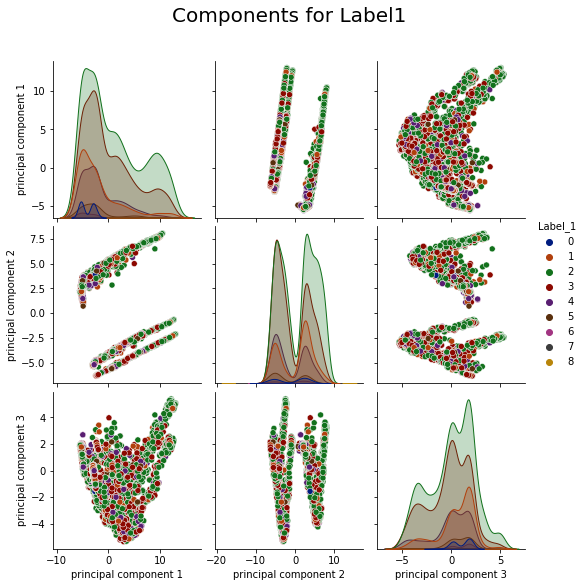

In [31]:
#sns.set(color_codes=True)
#sns.set_palette("Blues")

#fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1)
#ax.legend("ANSWER1_163")
#ax.grid()

plot = sns.pairplot(finalDf, hue="Label_1", palette="dark")#Spectral
plot.fig.suptitle("Components for Label1", size=20, y=1.08) 

plt.savefig("Results/Components_for_Label1.png")

In [ ]:
y_train.unique()

### Percentage of Explained variance by the 3 first components:

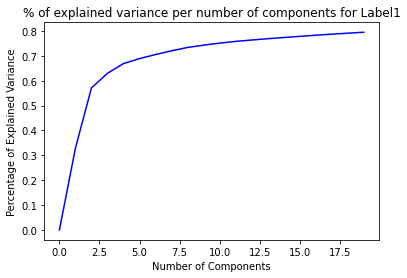

In [33]:
num_of_components = [i for i in range(n_components)]
explained_var     = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(n_components)]

plt.plot(num_of_components, explained_var, color = "blue")
plt.title("% of explained variance per number of components for Label1")
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Number of Components")
plt.savefig("Results/Percentage_of_explained_variance_for_PCA_over_Label1.png")

In [20]:
print("Percentage of explained variance of the first three components is equal to : {}".format(np.sum(pca.explained_variance_ratio_[:2])))

Percentage of explained variance of the first three components is equal to : 0.5709714928232524


### First three components are made of:

In [21]:
three_comp = pd.DataFrame(data =pca.components_[:3], columns = X_train.columns)
three_comp.describe()

,ID,ANSWER1_101,ANSWER2_101,ANSWER3_101,ANSWER4_101,ANSWER5_101,ANSWER6_101,ANSWER7_101,ANSCOUNT_101,INDICATORID_101,...,ANSWER4_316,ANSWER5_316,ANSWER6_316,ANSWER7_316,ANSCOUNT_316,INDICATORID_316,SUBINDICATORID_316,LEVEL1ID,SURVEYR,DEMCODE
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,-0.008286,0.014573,0.016523,0.005246,0.005632,0.003588,-0.000031,0.000099,0.001172,0.032189,...,0.000077,-0.000341,0.001400,0.001504,0.002333,0.000130,0.000130,-0.008323,0.000008,-0.000115
std,0.010617,0.031687,0.035710,0.011167,0.012563,0.007267,0.000362,0.000445,0.000203,0.069752,...,0.003006,0.005641,0.003528,0.005949,0.001382,0.000107,0.000107,0.010650,0.000053,0.000053
min,-0.018065,-0.016412,-0.016810,-0.004559,-0.005669,-0.002961,-0.000307,-0.000360,0.000938,-0.033618,...,-0.002129,-0.004660,-0.002600,-0.005283,0.000782,0.000012,0.000012,-0.018053,-0.000027,-0.000162
25%,-0.013933,-0.001599,-0.002320,-0.000832,-0.001131,-0.000322,-0.000236,-0.000116,0.001106,-0.004371,...,-0.001635,-0.003532,0.000065,-0.000653,0.001783,0.000086,0.000086,-0.014012,-0.000023,-0.000143
50%,-0.009800,0.013213,0.012169,0.002895,0.003407,0.002318,-0.000166,0.000128,0.001273,0.024875,...,-0.001142,-0.002405,0.002729,0.003977,0.002785,0.000159,0.000159,-0.009972,-0.000018,-0.000125
75%,-0.003397,0.030066,0.033190,0.010148,0.011283,0.006862,0.000107,0.000329,0.001289,0.065093,...,0.001180,0.001818,0.003400,0.004897,0.003109,0.000190,0.000190,-0.003459,0.000026,-0.000091
max,0.003007,0.046919,0.054210,0.017401,0.019159,0.011406,0.000379,0.000529,0.001306,0.105310,...,0.003501,0.006041,0.004071,0.005817,0.003433,0.000220,0.000220,0.003055,0.000070,-0.000057


In [22]:
three_comp.reset_index()
three_comp.head()

,ID,ANSWER1_101,ANSWER2_101,ANSWER3_101,ANSWER4_101,ANSWER5_101,ANSWER6_101,ANSWER7_101,ANSCOUNT_101,INDICATORID_101,...,ANSWER4_316,ANSWER5_316,ANSWER6_316,ANSWER7_316,ANSCOUNT_316,INDICATORID_316,SUBINDICATORID_316,LEVEL1ID,SURVEYR,DEMCODE
0,-0.018065,-0.016412,-0.016810,-0.004559,-0.005669,-0.002961,-0.000166,-0.000360,0.000938,-0.033618,...,0.003501,0.006041,-0.002600,-0.005283,0.002785,0.000159,0.000159,-0.018053,-0.000027,-0.000162
1,-0.009800,0.046919,0.054210,0.017401,0.019159,0.011406,0.000379,0.000529,0.001273,0.105310,...,-0.002129,-0.004660,0.004071,0.005817,0.000782,0.000220,0.000220,-0.009972,0.000070,-0.000125
2,0.003007,0.013213,0.012169,0.002895,0.003407,0.002318,-0.000307,0.000128,0.001306,0.024875,...,-0.001142,-0.002405,0.002729,0.003977,0.003433,0.000012,0.000012,0.003055,-0.000018,-0.000057


In [25]:
#most discriminant features for every component
colonnes=three_comp.columns
index_list=[]
for i in range(3):
    disc = pd.DataFrame(np.argsort(three_comp.abs().values)[i:i+1,-10:])
    index_list.append(colonnes[np.array(disc.values)][0][::-1])

<ipython-input-25-2d686bf1c5e1>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  index_list.append(colonnes[np.array(disc.values)][0][::-1])


In [26]:
index_list

[array(['SUBINDICATORID_176', 'INDICATORID_176', 'INDICATORID_173',
        'SUBINDICATORID_173', 'INDICATORID_186', 'SUBINDICATORID_186',
        'SUBINDICATORID_178', 'INDICATORID_178', 'INDICATORID_174',
        'SUBINDICATORID_174'], dtype=object),
 array(['SUBINDICATORID_136', 'INDICATORID_287', 'INDICATORID_136',
        'SUBINDICATORID_295', 'INDICATORID_295', 'INDICATORID_130',
        'SUBINDICATORID_130', 'SUBINDICATORID_312', 'SUBINDICATORID_287',
        'INDICATORID_312'], dtype=object),
 array(['SUBINDICATORID_309', 'INDICATORID_309', 'INDICATORID_303',
        'SUBINDICATORID_303', 'SUBINDICATORID_310', 'INDICATORID_310',
        'ANSWER1_309', 'ANSWER2_169', 'ANSWER2_233', 'SUBINDICATORID_233'],
       dtype=object)]

In [27]:
new_index_list=np.vstack((index_list[0],index_list[1], index_list[2]))
pd.DataFrame(new_index_list).to_csv("Results/important_features_for_first_3_PCA_components_Label_1.csv")